## Project: Development of a reduced pediatric injury prediction model
Created by: Thomas Hartka, MD, MS  
Date created: 12/20/20  
  
This notebook the maximum AUC for models with different numbers of variables.  We also create the same plot, but exclude delta-V as a predictor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

## Set outcome

In [2]:
# outcome of interest
#  ISS -> ISS>=16
#  TIL -> any injury on target injury list
outcome = "ISS"

## Read in results

In [3]:
if outcome == "ISS":
    results = pd.read_csv("../Results/Model_avg_10x-ISS.csv")
elif outcome == "TIL":
    results = pd.read_csv("../Results/Model_avg_10x-TIL.csv")
else:
    raise Exception("Outcome not valid") 

In [4]:
predictors = ['sex','age_5_9', 'age_10_14','age_15_18',
              'prop_restraint','no_restraint','front_row', 
              'dvtotal','pdof_rear','pdof_nearside','pdof_farside', 
              'rolled','multicoll','ejection']

## Calculate mean and 95% CI of AUCs

In [5]:
# copy into new dataframe for binary variables instead of coefficients
results_bin = results.copy()

# convert cofficients to binary flags
results_bin[predictors] = results[predictors].applymap(lambda x: 1 if x!=0 else 0) 

In [6]:
# calculate mean and standard deviation of all models
mean_AUC = results_bin.groupby(['num_vars']+predictors)['AUC'].agg(['mean', 'std'])

# find max mean AUC for each number of variables and select for those rows
max_idx = mean_AUC.groupby(['num_vars'])['mean'].transform(max) == mean_AUC['mean']
max_AUC = mean_AUC[max_idx].reset_index()

# calculate lower and upper 95% CI
max_AUC['LL'] = max_AUC['mean'] - 1.96*max_AUC['std']
max_AUC['UL'] = max_AUC['mean'] + 1.96*max_AUC['std']

# discard unneeded columns
max_AUC = max_AUC[['num_vars','mean','LL','UL']]

max_AUC

,num_vars,mean,LL,UL
0,1.0,0.846434,0.805656,0.887212
1,2.0,0.881323,0.829801,0.932846
2,3.0,0.892314,0.837343,0.947285
3,4.0,0.899511,0.850443,0.948579
4,5.0,0.906390,0.863095,0.949685
5,6.0,0.907981,0.864773,0.951189
6,7.0,0.908532,0.866174,0.950889
7,8.0,0.908591,0.866121,0.951062
8,9.0,0.908486,0.866206,0.950766
9,10.0,0.908317,0.865695,0.950940


## Calculate stat significant decrease in AUC

In [7]:
# store base model results
base_distrib = results_bin[results_bin.num_vars==14]['AUC']

# create arrary for max p-values
max_p = [0] * 14

# group results by model
results_grp = results_bin.groupby(['num_vars']+predictors)['AUC']

# iterate through models
for num_vars, model_results in results_grp:
    # compare to baseline model
    p = stats.ttest_rel(base_distrib, model_results).pvalue
    
    # test if this is the highest p-value
    if p > max_p[num_vars[0].astype(int)-1]:
        max_p[num_vars[0].astype(int)-1] = p
    # if the distributions are identical
    elif np.isnan(p):
        max_p[num_vars[0].astype(int)-1] = 1.0

max_p

[3.6407729089222502e-06,
 0.00043068299769096407,
 0.012872951504584949,
 0.07172507707783758,
 0.8755255633471195,
 0.9668197246254963,
 0.9710509852128767,
 0.9685763714664746,
 0.9926537250543378,
 0.9999803635195508,
 0.9919430465521915,
 0.9925676534806721,
 0.9310401278584225,
 1.0]

In [8]:
# loop through variable numbers
for i in range(0,len(predictors)):
    
    # check if best model is statistically sig different than base model
    if max_p[i] > 0.05:
        
        # if so, store value and break
        num_var_sd = i
        break

num_var_sd

3

## Plot AUC versus number of variables

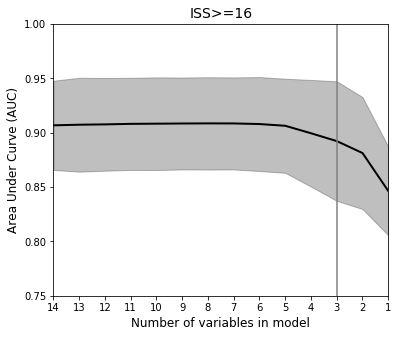

In [9]:
# set up plot
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

# add data for line plot and 95% CI 
ax.plot(max_AUC['num_vars'], max_AUC['mean'], marker='', color='black', linewidth=2, alpha=1)
ax.fill_between(max_AUC['num_vars'], max_AUC['LL'], max_AUC['UL'],color='black',alpha=0.25)

# set plot limits
plt.ylim(0.75, 1.0)
plt.xlim(13, 1)

# add line for statistically sign decrease in AUC
ax.axvline(x=num_var_sd, linestyle='-', color='grey')

# correct tick marks
ax.set_xticks(max_AUC['num_vars'].unique())

# label axes
plt.xlabel('Number of variables in model', fontsize=12)
plt.ylabel('Area Under Curve (AUC)', fontsize=12)

# title
if outcome == "ISS":
    plt.title("ISS>=16", fontsize=14)
elif outcome == "TIL":
    plt.title("Target injury list", fontsize=14)

plt.show()

## Calculate AUC excluding models with delta-V

In [10]:
# copy into new dataframe but only include models without delta-V
results_bin_wo_dv = results[results.dvtotal==0].copy()

# convert cofficients to binary flags
results_bin_wo_dv[predictors] = results_bin_wo_dv[predictors].applymap(lambda x: 1 if x!=0 else 0) 

# calculate mean and standard deviation of all models
mean_AUC_wo_dv = results_bin_wo_dv.groupby(['num_vars']+predictors)['AUC'].agg(['mean', 'std'])

# find max mean AUC for each number of variables and select for those rows
max_idx_wo_dv = mean_AUC_wo_dv.groupby(['num_vars'])['mean'].transform(max) == mean_AUC_wo_dv['mean']
max_AUC_wo_dv = mean_AUC_wo_dv[max_idx_wo_dv].reset_index()

# calculate lower and upper 95% CI
max_AUC_wo_dv['LL'] = max_AUC_wo_dv['mean'] - 1.96*max_AUC_wo_dv['std']
max_AUC_wo_dv['UL'] = max_AUC_wo_dv['mean'] + 1.96*max_AUC_wo_dv['std']

## Calculate stat significant decrease in AUC excluding delta-V

In [11]:
# store base model results
base_distrib = results_bin_wo_dv[results_bin_wo_dv.num_vars==13]['AUC']

# create arrary for max p-values
max_p_wo_dv = [0] * 13

# group results by model
results_grp = results_bin_wo_dv.groupby(['num_vars']+predictors)['AUC']

# iterate through models
for num_vars, model_results in results_grp:
    # compare to baseline model
    p = stats.ttest_rel(base_distrib, model_results).pvalue
    
    # test if this is the highest p-value
    if p > max_p_wo_dv[num_vars[0].astype(int)-1]:
        max_p_wo_dv[num_vars[0].astype(int)-1] = p
    # if the distributions are identical
    elif np.isnan(p):
        max_p_wo_dv[num_vars[0].astype(int)-1] = 1.0

max_p_wo_dv

[2.5047705022339425e-06,
 2.157576826577909e-05,
 0.00014429311865128087,
 0.0049728958275136615,
 0.06111084643723168,
 0.2498417184466346,
 0.7657103840705277,
 0.7403021769713932,
 0.9165241311534569,
 0.9907385820399552,
 0.9874971657628167,
 0.9566555000602217,
 1.0]

In [12]:
# loop through variable numbers
for i in range(0,len(predictors)-1):
    
    # check if best model is statistically sig different than base model
    if max_p_wo_dv[i] > 0.05:
        
        # if so, store value and break
        num_var_sd_wo_dv = i
        break

num_var_sd_wo_dv

4

## Plot AUC vs variable number excluding delta-V

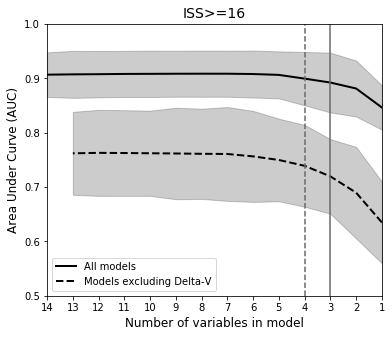

In [14]:
# set up plot
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

# add data for line plot and 95% CI 
ax.plot(max_AUC['num_vars'], max_AUC['mean'], color='black', linewidth=2, alpha=1, label='All models')
ax.plot(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['mean'], linestyle='--', color='black', linewidth=2, alpha=1, label="Models excluding Delta-V")
ax.fill_between(max_AUC['num_vars'], max_AUC['LL'], max_AUC['UL'],color='black',alpha=0.25)
ax.fill_between(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['LL'], max_AUC_wo_dv['UL'],color='black',alpha=0.25)
#ax.fill_between(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['LL'], max_AUC_wo_dv['UL'],color='black',alpha=0.25,hatch="/")

# set plot limits
plt.ylim(0.5, 1.0)
plt.xlim(13, 1)

# add line for statistically sign decrease in AUC
ax.axvline(x=num_var_sd, linestyle='-', color='dimgrey')
ax.axvline(x=num_var_sd_wo_dv, linestyle='--', color='dimgrey')

# correct tick marks
ax.set_xticks(max_AUC['num_vars'].unique())

# add legend
plt.legend(loc="lower left")

# label axes
plt.xlabel('Number of variables in model', fontsize=12)
plt.ylabel('Area Under Curve (AUC)', fontsize=12)

# title
if outcome == "ISS":
    plt.title("ISS>=16", fontsize=14)
elif outcome == "TIL":
    plt.title("Target injury list", fontsize=14)

plt.show()